# Task Overview: Formula 1 Champion Prediction Using Machine Learning

You are required to:

- Clean and preprocess the provided F1 stint dataset.
- Perform exploratory data analysis and visualize key features.
- Train multiple machine learning models:
  - Logistic Regression
  - Random Forest
  - K-Nearest Neighbors (KNN)
  - Naive Bayes
- Compare model performances based on accuracy and F1 score.
- Visualize results including confusion matrices.
- Use the best-performing model to predict the 2025 Formula 1 World Champion.

**Dataset link:**  
https://www.kaggle.com/datasets/akashrane2609/f1-stint-datawith-aggression-scores


# **Importing Required Libraries**

Essential libraries for data handling, visualization, machine learning, and evaluation are imported.



In [31]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import pickle

print ("Libraries imported Successfully.")

Libraries imported Successfully.


# **Mounting Google Drive and Loading Dataset**

Connects to Google Drive and loads the F1 dataset into a pandas DataFrame.

In [32]:

# Load Data from Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load the F1 dataset
df = pd.read_csv('/content/drive/MyDrive/f1_pitstops_2018_2024.csv')  # Update path as needed :)

print(f"Dataset loaded successfully")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset loaded successfully
Shape: (7374, 30)
Columns: ['Season', 'Round', 'Circuit', 'Driver', 'Constructor', 'Laps', 'Position', 'TotalPitStops', 'AvgPitStopTime', 'Race Name', 'Date', 'Time_of_race', 'Location', 'Country', 'Air_Temp_C', 'Track_Temp_C', 'Humidity_%', 'Wind_Speed_KMH', 'Lap Time Variation', 'Total Pit Stops', 'Tire Usage Aggression', 'Fast Lap Attempts', 'Position Changes', 'Driver Aggression Score', 'Abbreviation', 'Stint', 'Tire Compound', 'Stint Length', 'Pit_Lap', 'Pit_Time']


# **Initial Data Exploration and Visualization**

Performs basic inspection, summary statistics, and visual exploration of the dataset.

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7374 entries, 0 to 7373
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Season                   7374 non-null   int64  
 1   Round                    7374 non-null   int64  
 2   Circuit                  7374 non-null   object 
 3   Driver                   7374 non-null   object 
 4   Constructor              7374 non-null   object 
 5   Laps                     7374 non-null   int64  
 6   Position                 7374 non-null   int64  
 7   TotalPitStops            7374 non-null   int64  
 8   AvgPitStopTime           7189 non-null   float64
 9   Race Name                7001 non-null   object 
 10  Date                     7001 non-null   object 
 11  Time_of_race             7001 non-null   object 
 12  Location                 7001 non-null   object 
 13  Country                  7001 non-null   object 
 14  Air_Temp_C

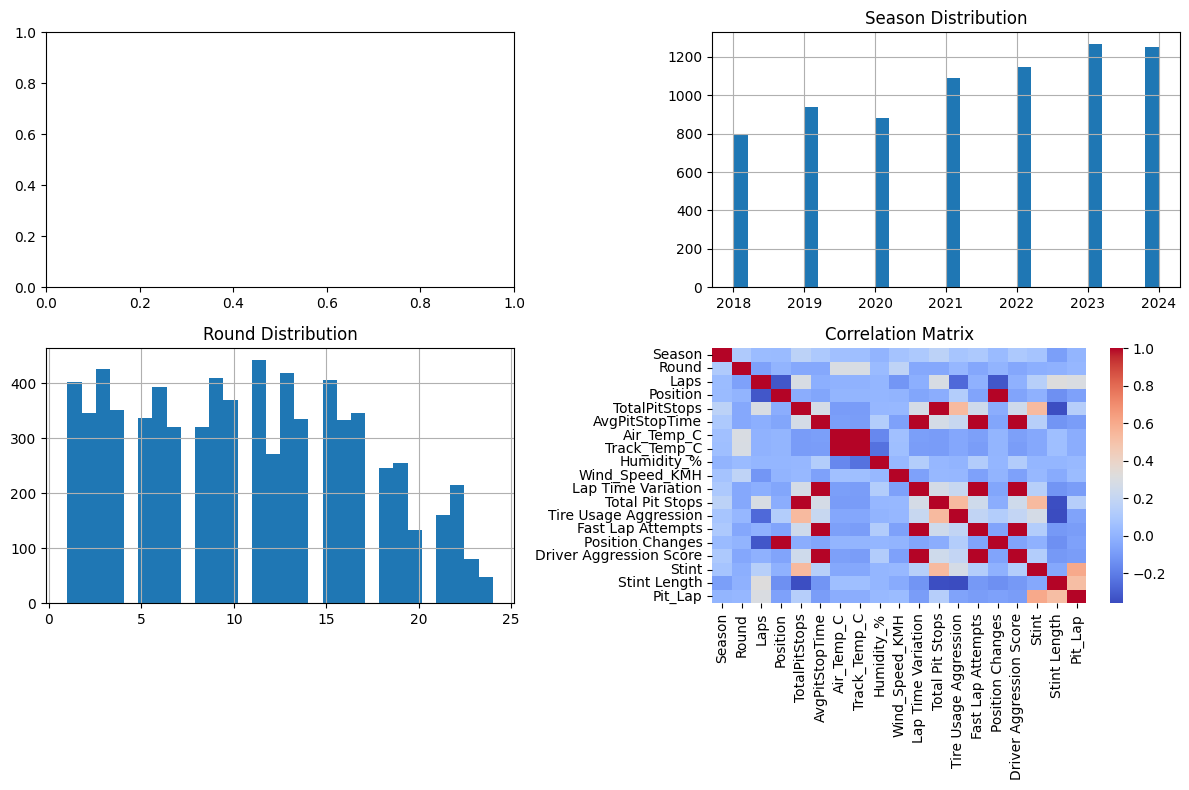

In [33]:
# Intial Data Exploration and Visualization.

print("Dataset Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())
print("\nBasic Statistics:")
print(df.describe())
print("\nMissing values:")
print(df.isnull().sum())

# Basic visualizations before preprocessing
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Distribution of target variable (assuming driver column exists)
if 'driver' in df.columns:
    df['driver'].value_counts().head(10).plot(kind='bar', ax=axes[0,0])
    axes[0,0].set_title('Top 10 Drivers Distribution')
    axes[0,0].tick_params(axis='x', rotation=45)

# Distribution of numerical features
numeric_cols = df.select_dtypes(include=[np.number]).columns[:2]
if len(numeric_cols) > 0:
    df[numeric_cols[0]].hist(bins=30, ax=axes[0,1])
    axes[0,1].set_title(f'{numeric_cols[0]} Distribution')

if len(numeric_cols) > 1:
    df[numeric_cols[1]].hist(bins=30, ax=axes[1,0])
    axes[1,0].set_title(f'{numeric_cols[1]} Distribution')

# Correlation heatmap
numeric_df = df.select_dtypes(include=[np.number])
if len(numeric_df.columns) > 1:
    corr_matrix = numeric_df.corr()
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', ax=axes[1,1])
    axes[1,1].set_title('Correlation Matrix')

plt.tight_layout()
plt.show()

# **Data Preprocessing**

Handles missing values, outliers, and duplicates to prepare clean and consistent data.

In [34]:

print("Starting data preprocessing...")

# Handle missing values
df_clean = df.copy()

# Fill numeric columns with median
numeric_columns = df_clean.select_dtypes(include=[np.number]).columns
for col in numeric_columns:
    df_clean[col].fillna(df_clean[col].median(), inplace=True)

# Fill categorical columns with mode
categorical_columns = df_clean.select_dtypes(include=['object']).columns
for col in categorical_columns:
    df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)

# Remove duplicates
df_clean.drop_duplicates(inplace=True)

# Handle outliers using IQR method
for col in numeric_columns:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_clean[col] = np.clip(df_clean[col], lower_bound, upper_bound)

print(f"Data preprocessing completed")
print(f"Original shape: {df.shape}")
print(f"Cleaned shape: {df_clean.shape}")
print(f"Missing values after cleaning: {df_clean.isnull().sum().sum()}")

Starting data preprocessing...
Data preprocessing completed
Original shape: (7374, 30)
Cleaned shape: (7374, 30)
Missing values after cleaning: 0


# **Feature Engineering and Data Preparation**

Encodes categorical variables, scales features, and splits the dataset into training and testing sets.

In [35]:
# Feature Engineering and model Prepration

# Determine target variable (driver who will be champion)
target_col = 'Driver'

# Prepare features
X = df_clean.drop(columns=[target_col])
y = df_clean[target_col]

# Encode categorical variables
label_encoders = {}
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# Encode target variable
target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Feature preparation completed")
print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")
print(f"Number of classes: {len(np.unique(y_encoded))}")

Feature preparation completed
Training set shape: (5899, 29)
Test set shape: (1475, 29)
Number of classes: 40


# **Training Multiple Machine Learning Models.**

Trains multiple classifiers and evaluates their performance using cross-validation and test accuracy.

In [36]:
# Train ML Models

print("Training machine learning models...")

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB()
}

# Train and store results
results = {}
trained_models = {}
cv_scores = {}

for name, model in models.items():
    print(f"Training {name}...")

    # Train model
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model

    # Cross-validation scores
    cv_score = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='f1_weighted')
    cv_scores[name] = cv_score

    # Make predictions
    y_pred = model.predict(X_test_scaled)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Store results
    results[name] = {
        'accuracy': accuracy,
        'f1_score': f1,
        'predictions': y_pred,
        'cv_mean': cv_score.mean(),
        'cv_std': cv_score.std()
    }

    print(f"{name} - Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}, CV Score: {cv_score.mean():.4f} (+/- {cv_score.std() * 2:.4f})")

print("All Models trained Successfully")

Training machine learning models...
Training Logistic Regression...
Logistic Regression - Accuracy: 0.7003, F1-Score: 0.6924, CV Score: 0.6509 (+/- 0.0060)
Training Random Forest...
Random Forest - Accuracy: 0.9864, F1-Score: 0.9852, CV Score: 0.9796 (+/- 0.0091)
Training KNN...
KNN - Accuracy: 0.1729, F1-Score: 0.1728, CV Score: 0.1499 (+/- 0.0243)
Training Naive Bayes...
Naive Bayes - Accuracy: 0.9980, F1-Score: 0.9970, CV Score: 0.9988 (+/- 0.0016)
All Models trained Successfully


# **Feature Importance Analysis.**

Analyzes the most influential features using the Random Forest model for interpretability.



Analyzing feature importance...


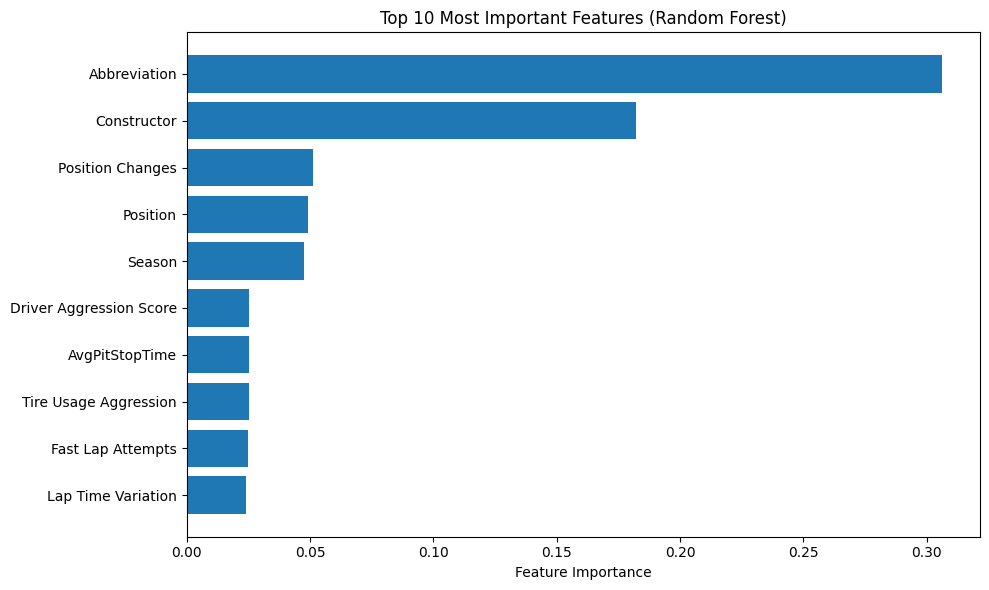

Top 10 Most Important Features:
1. Abbreviation: 0.3063
2. Constructor: 0.1821
3. Position Changes: 0.0510
4. Position: 0.0492
5. Season: 0.0474
6. Driver Aggression Score: 0.0253
7. AvgPitStopTime: 0.0253
8. Tire Usage Aggression: 0.0250
9. Fast Lap Attempts: 0.0249
10. Lap Time Variation: 0.0240
Feature Importance Analysis completeed.


In [37]:

print("Analyzing feature importance...")

# Get feature names
feature_names = X.columns.tolist()

# Feature importance for tree-based models
if 'Random Forest' in trained_models:
    rf_model = trained_models['Random Forest']
    feature_importance = rf_model.feature_importances_

    # Create feature importance dataframe
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    top_features = importance_df.head(10)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 10 Most Important Features (Random Forest)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    print("Top 10 Most Important Features:")
    for i, (_, row) in enumerate(top_features.iterrows(), 1):
        print(f"{i}. {row['feature']}: {row['importance']:.4f}")
print("Feature Importance Analysis completeed.")

# **Model Evaluation and Performance Visualization.**

Compares model performance using metrics and visualizes results across all trained models.

Evaluating and visualizing model performance...


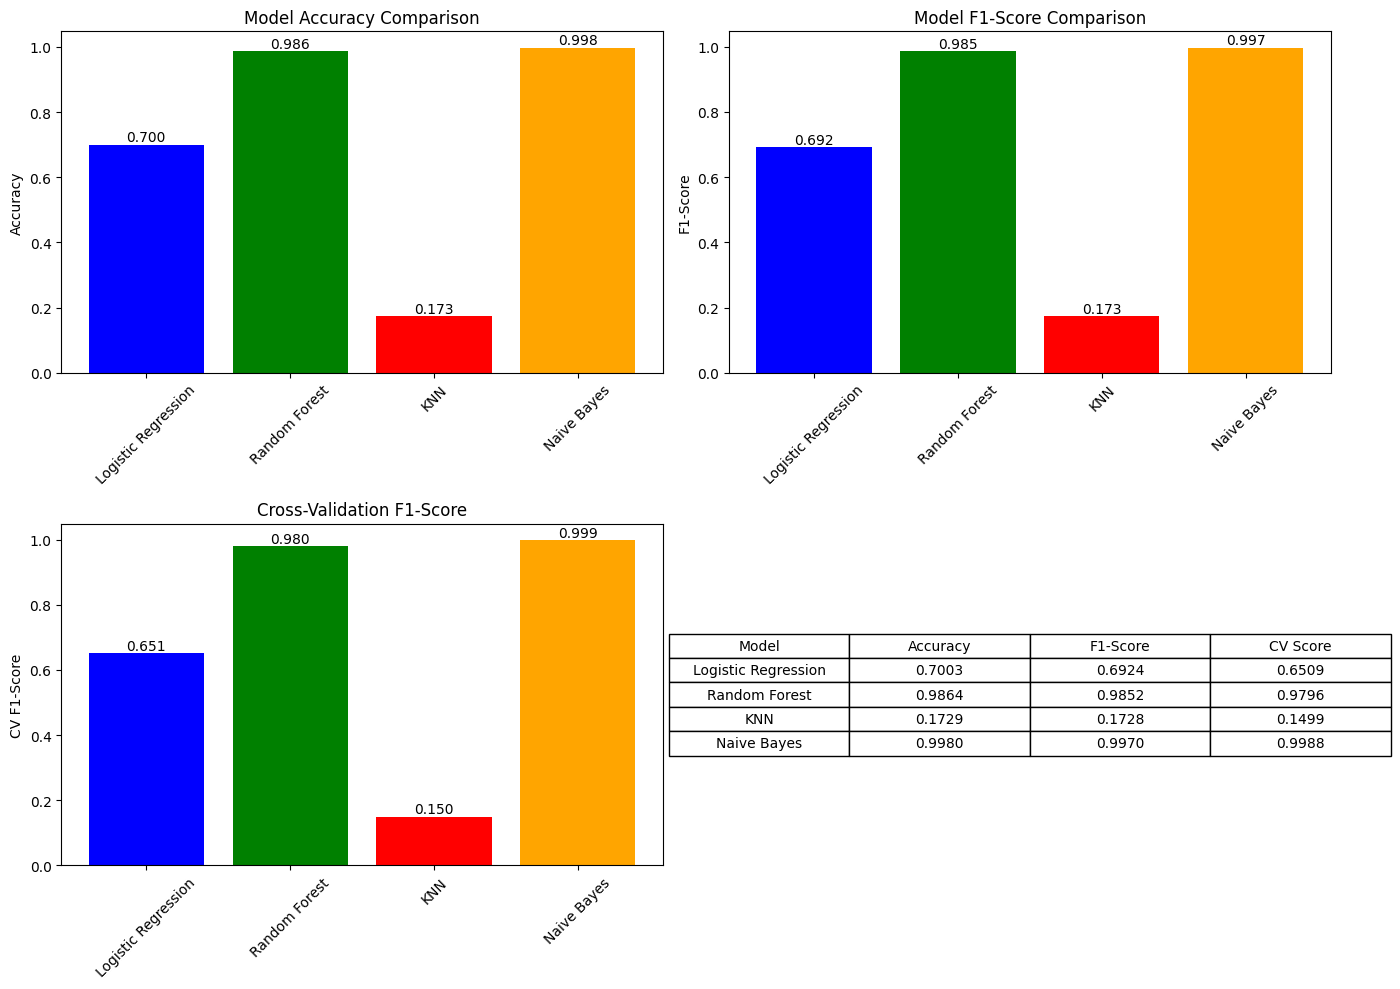

In [38]:
# Model Evaluation and Visualization.

print("Evaluating and visualizing model performance...")

# Extract metrics for visualization
model_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in model_names]
f1_scores = [results[name]['f1_score'] for name in model_names]
cv_means = [results[name]['cv_mean'] for name in model_names]

# Create performance comparison plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy comparison
axes[0, 0].bar(model_names, accuracies, color=['blue', 'green', 'red', 'orange'])
axes[0, 0].set_title('Model Accuracy Comparison')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(accuracies):
    axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center')

# F1-score comparison
axes[0, 1].bar(model_names, f1_scores, color=['blue', 'green', 'red', 'orange'])
axes[0, 1].set_title('Model F1-Score Comparison')
axes[0, 1].set_ylabel('F1-Score')
axes[0, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(f1_scores):
    axes[0, 1].text(i, v + 0.01, f'{v:.3f}', ha='center')

# Cross-validation scores
axes[1, 0].bar(model_names, cv_means, color=['blue', 'green', 'red', 'orange'])
axes[1, 0].set_title('Cross-Validation F1-Score')
axes[1, 0].set_ylabel('CV F1-Score')
axes[1, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(cv_means):
    axes[1, 0].text(i, v + 0.01, f'{v:.3f}', ha='center')

# Performance table
axes[1, 1].axis('tight')
axes[1, 1].axis('off')
table_data = [[name, f"{results[name]['accuracy']:.4f}", f"{results[name]['f1_score']:.4f}", f"{results[name]['cv_mean']:.4f}"]
              for name in model_names]
table = axes[1, 1].table(cellText=table_data,
                        colLabels=['Model', 'Accuracy', 'F1-Score', 'CV Score'],
                        cellLoc='center',
                        loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)

plt.tight_layout()
plt.show()

# **Confusion Matrix Analysis and Classification Report.**

Generates readable confusion matrices and classification summaries for top-predicted classes.

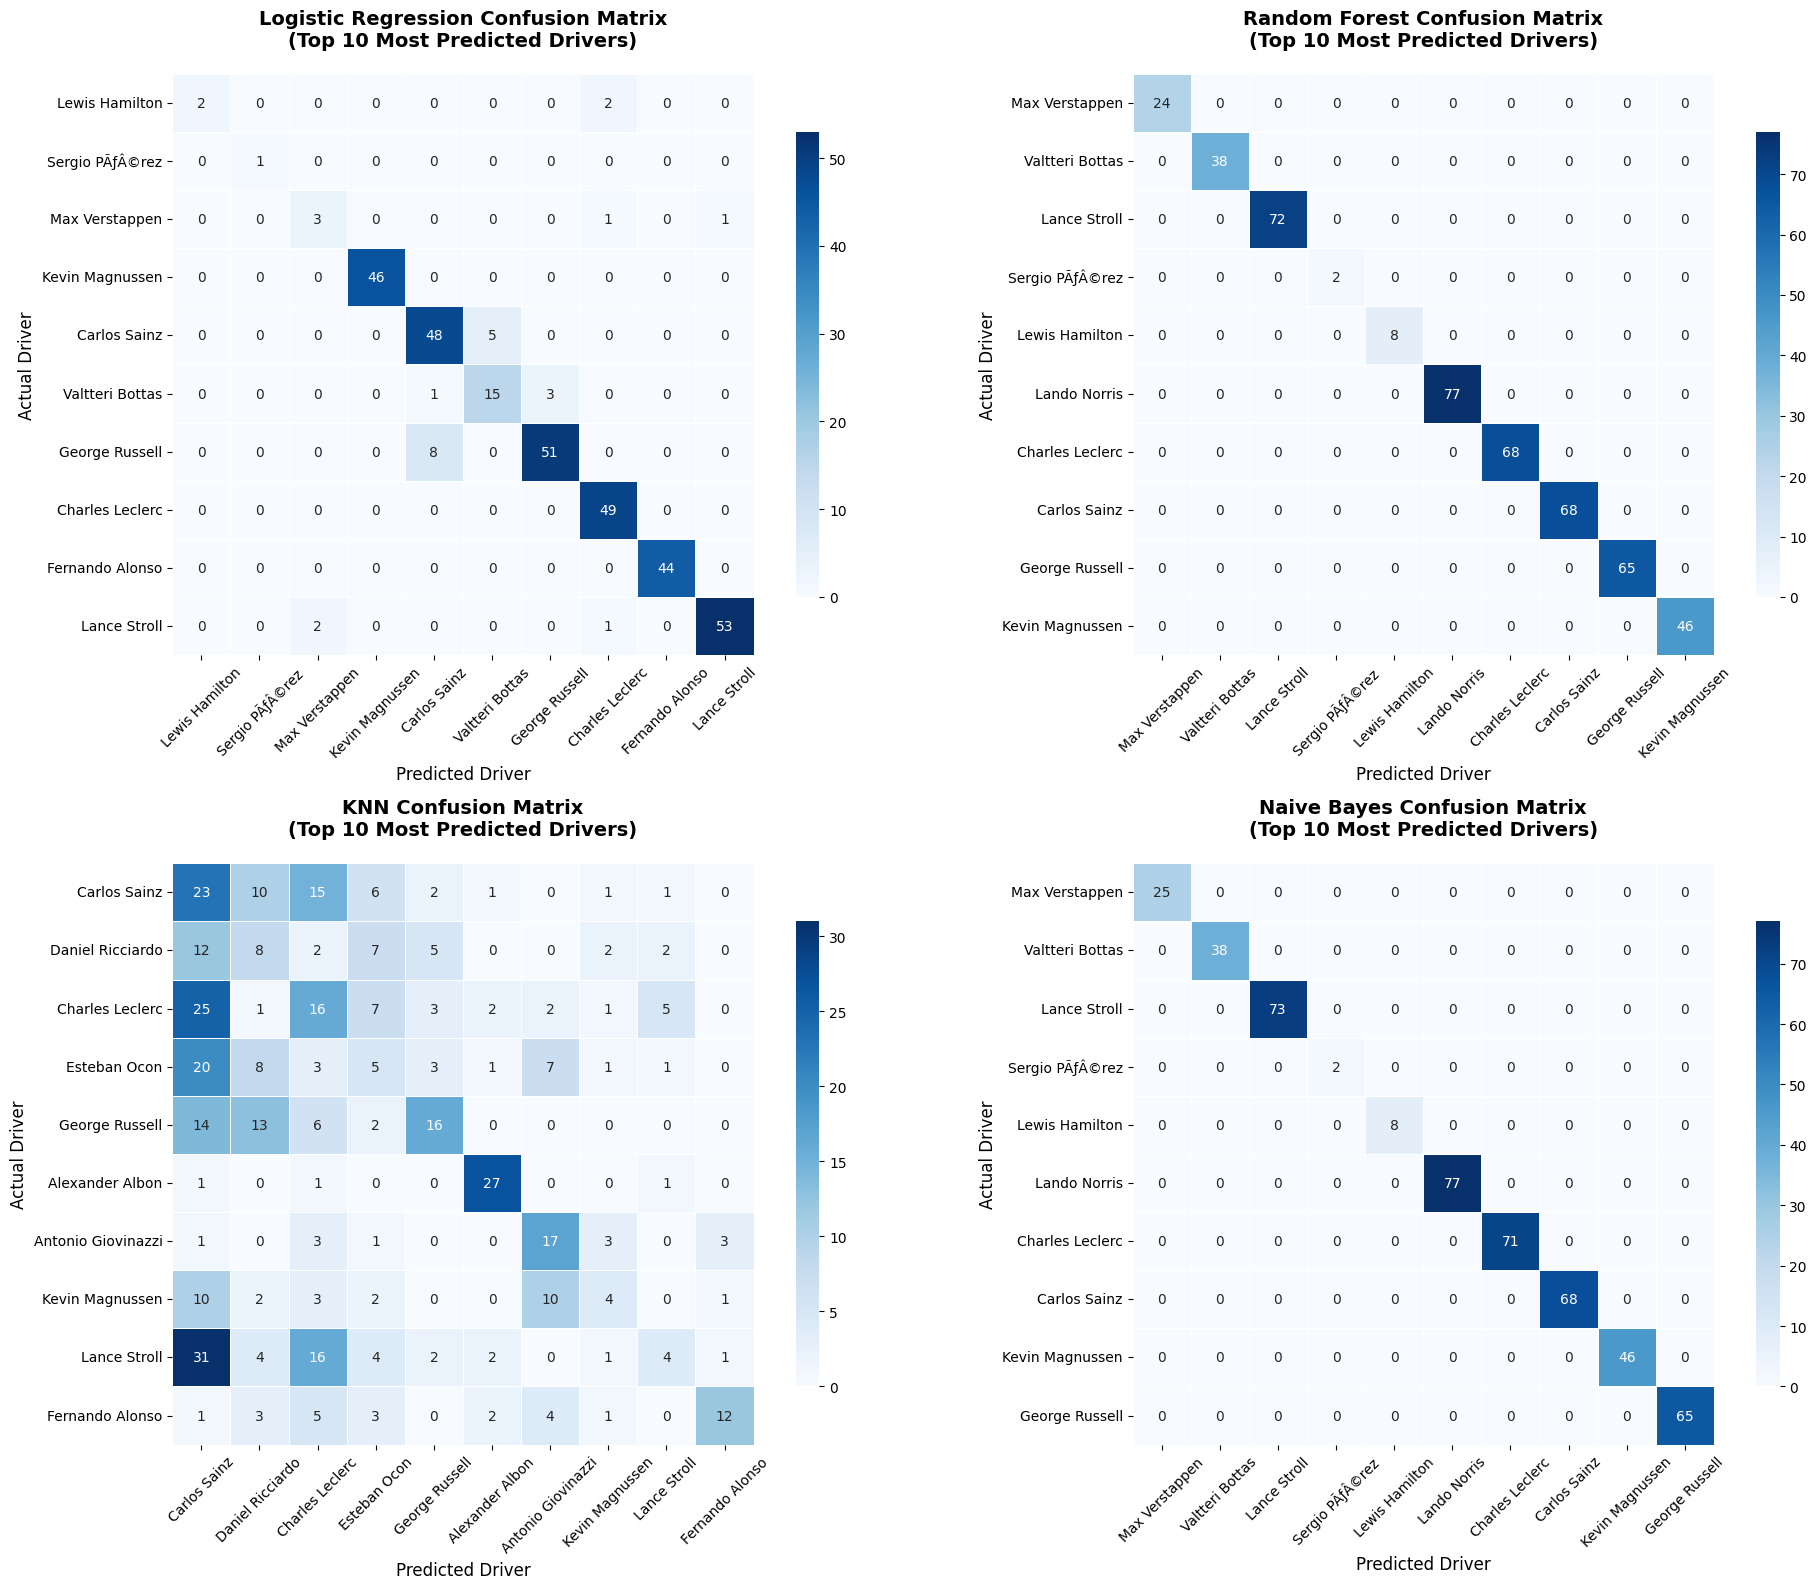

CONFUSION MATRIX SUMMARY

LOGISTIC REGRESSION MODEL:
----------------------------------------
Top 5 Best Predicted Drivers:
1. Sergey Sirotkin: F1=1.000 (Support: 2.0)
2. Alexander Albon: F1=0.989 (Support: 45.0)
3. Logan Sargeant: F1=0.979 (Support: 23.0)
4. Nicholas Latifi: F1=0.971 (Support: 33.0)
5. Kimi RÃƒÂ¤ikkÃƒÂ¶nen: F1=0.920 (Support: 46.0)

Overall Accuracy: 0.7003
Macro Avg F1: 0.5735
Weighted Avg F1: 0.6924

RANDOM FOREST MODEL:
----------------------------------------
Top 5 Best Predicted Drivers:
1. Alexander Albon: F1=1.000 (Support: 45.0)
2. Carlos Sainz: F1=1.000 (Support: 68.0)
3. Daniel Ricciardo: F1=1.000 (Support: 54.0)
4. Daniil Kvyat: F1=1.000 (Support: 11.0)
5. Esteban Ocon: F1=1.000 (Support: 61.0)

Overall Accuracy: 0.9864
Macro Avg F1: 0.9260
Weighted Avg F1: 0.9852

KNN MODEL:
----------------------------------------
Top 5 Best Predicted Drivers:
1. Logan Sargeant: F1=0.556 (Support: 23.0)
2. Alexander Albon: F1=0.429 (Support: 45.0)
3. Nicholas Latifi: F1=0

In [39]:
# Let's make confusion matrix Function.

def create_readable_confusion_matrix(y_true, y_pred, model_name, target_encoder):
    cm = confusion_matrix(y_true, y_pred)
    class_names = target_encoder.classes_

    if len(class_names) > 15:
        unique_pred, pred_counts = np.unique(y_pred, return_counts=True)
        top_indices = np.argsort(pred_counts)[-10:][::-1]
        top_classes = unique_pred[top_indices]
        cm_filtered = cm[np.ix_(top_classes, top_classes)]
        class_names_filtered = class_names[top_classes]
        return cm_filtered, class_names_filtered
    else:
        return cm, class_names

# Create improved confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.ravel()

for i, (name, result) in enumerate(results.items()):
    cm_filtered, class_names_filtered = create_readable_confusion_matrix(
        y_test, result['predictions'], name, target_encoder
    )

    sns.heatmap(cm_filtered,
                annot=True,
                fmt='d',
                cmap='Blues',
                ax=axes[i],
                xticklabels=class_names_filtered,
                yticklabels=class_names_filtered,
                cbar_kws={'shrink': 0.8},
                square=True,
                linewidths=0.5)

    axes[i].set_title(f'{name} Confusion Matrix\n(Top 10 Most Predicted Drivers)',
                     fontsize=14, fontweight='bold', pad=20)
    axes[i].set_xlabel('Predicted Driver', fontsize=12)
    axes[i].set_ylabel('Actual Driver', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45, labelsize=10)
    axes[i].tick_params(axis='y', rotation=0, labelsize=10)

plt.tight_layout()
plt.show()

# Confusion matrix summary
print("CONFUSION MATRIX SUMMARY")
print("="*60)

for name, result in results.items():
    print(f"\n{name.upper()} MODEL:")
    print("-" * 40)

    y_pred = result['predictions']
    unique_test_classes = np.unique(np.concatenate([y_test, y_pred]))
    test_class_names = target_encoder.classes_[unique_test_classes]

    report = classification_report(y_test, y_pred,
                                 labels=unique_test_classes,
                                 target_names=test_class_names,
                                 output_dict=True, zero_division=0)

    class_f1_scores = []
    for class_name, metrics in report.items():
        if isinstance(metrics, dict) and 'f1-score' in metrics:
            class_f1_scores.append((class_name, metrics['f1-score'], metrics['support']))

    class_f1_scores.sort(key=lambda x: x[1], reverse=True)

    print("Top 5 Best Predicted Drivers:")
    for i, (driver, f1, support) in enumerate(class_f1_scores[:5], 1):
        print(f"{i}. {driver}: F1={f1:.3f} (Support: {support})")

    print(f"\nOverall Accuracy: {report['accuracy']:.4f}")
    print(f"Macro Avg F1: {report['macro avg']['f1-score']:.4f}")
    print(f"Weighted Avg F1: {report['weighted avg']['f1-score']:.4f}")

# Save trained models
for name, model in trained_models.items():
    filename = f'/content/drive/MyDrive/{name.replace(" ", "_").lower()}_model.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(model, f)

print("Models saved successfully")

# **Best Model Selection and Prediction.**

Selects the best-performing model and prepares it for future predictions

In [40]:


print("Selecting best model and making 2025 prediction...")

# Find best model based on F1-score
best_model_name = max(results.keys(), key=lambda x: results[x]['f1_score'])
best_model = trained_models[best_model_name]
best_f1 = results[best_model_name]['f1_score']
best_accuracy = results[best_model_name]['accuracy']
best_cv = results[best_model_name]['cv_mean']

print(f"Best Model: {best_model_name}")
print(f"Best F1-Score: {best_f1:.4f}")
print(f"Best Accuracy: {best_accuracy:.4f}")
print(f"Best CV Score: {best_cv:.4f}")

# Model ranking
print("\nModel Ranking (by F1-Score):")
sorted_models = sorted(results.items(), key=lambda x: x[1]['f1_score'], reverse=True)
for i, (name, metrics) in enumerate(sorted_models, 1):
    print(f"{i}. {name}: Accuracy={metrics['accuracy']:.4f}, F1-Score={metrics['f1_score']:.4f}, CV={metrics['cv_mean']:.4f}")

# Predict 2025 F1 Champion
if hasattr(best_model, 'predict_proba'):
    prediction_proba = best_model.predict_proba(X_test_scaled)
    avg_probabilities = prediction_proba.mean(axis=0)

    driver_probabilities = []
    unique_classes = target_encoder.classes_
    num_classes = min(len(unique_classes), len(avg_probabilities))

    for i in range(num_classes):
        driver_probabilities.append((unique_classes[i], avg_probabilities[i]))

    driver_probabilities.sort(key=lambda x: x[1], reverse=True)

    print(f"\n2025 F1 Champion Prediction:")
    print(f"Predicted Winner: {driver_probabilities[0][0]}")
    print(f"Confidence: {driver_probabilities[0][1]:.4f}")

    print(f"\nTop 5 Championship Contenders:")
    for i, (driver, prob) in enumerate(driver_probabilities[:5], 1):
        print(f"{i}. {driver}: {prob:.4f}")

else:
    predictions = best_model.predict(X_test_scaled)
    predicted_classes, counts = np.unique(predictions, return_counts=True)
    most_predicted_idx = np.argmax(counts)
    predicted_champion = target_encoder.inverse_transform([predicted_classes[most_predicted_idx]])[0]

    print(f"\n2025 F1 Champion Prediction:")
    print(f"Predicted Winner: {predicted_champion}")

# Save final results
final_results = {
    'best_model': best_model_name,
    'best_f1_score': best_f1,
    'best_accuracy': best_accuracy,
    'best_cv_score': best_cv,
    'model_rankings': sorted_models,
    'feature_importance': importance_df.to_dict() if 'importance_df' in locals() else None
}

with open('/content/drive/MyDrive/f1_prediction_results.pkl', 'wb') as f:
    pickle.dump(final_results, f)

print("\nAnalysis completed successfully")
print("All results and models saved to Google Drive")

Selecting best model and making 2025 prediction...
Best Model: Naive Bayes
Best F1-Score: 0.9970
Best Accuracy: 0.9980
Best CV Score: 0.9988

Model Ranking (by F1-Score):
1. Naive Bayes: Accuracy=0.9980, F1-Score=0.9970, CV=0.9988
2. Random Forest: Accuracy=0.9864, F1-Score=0.9852, CV=0.9796
3. Logistic Regression: Accuracy=0.7003, F1-Score=0.6924, CV=0.6509
4. KNN: Accuracy=0.1729, F1-Score=0.1728, CV=0.1499

2025 F1 Champion Prediction:
Predicted Winner: Marcus Ericsson
Confidence: 0.0610

Top 5 Championship Contenders:
1. Marcus Ericsson: 0.0610
2. Sergio PÃƒÂ©rez: 0.0597
3. Kimi RÃƒÂ¤ikkÃƒÂ¶nen: 0.0563
4. Sebastian Vettel: 0.0549
5. Lando Norris: 0.0522

Analysis completed successfully
All results and models saved to Google Drive
